# Assignment 3
Welcome to the third programming assignment for the course. This assignments will help to familiarise you with Boolean function oracles while revisiting the topics discussed in this week's lectures. 

### Submission Guidelines
For final submission, and to ensure that you have no errors in your solution, please use the 'Restart and Run All' option availble in the Kernel menu at the top of the page. 
To submit your solution, run the completed notebook and attach the solved notebook (with results visible) as a .ipynb file using the 'Add or Create' option under the 'Your Work' heading on the assignment page in Google Classroom. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import *
from qiskit.quantum_info import *
basis_gates = ['id', 'x', 'y', 'z', 's', 't', 'sdg', 'tdg', 'h', 'p', 'sx' ,'r', 'rx', 'ry', 'rz', 'u', 'u1', 'u2', 'u3', 'cx', 'ccx', 'barrier', 'measure', 'snapshot']

## A quantum oracle implementation of the classical OR operation
We've already seen that the Toffoli gate implements the quantum version of the classical AND operation. The first part of this exercise will require you to construct such a quantum implementation for the OR operation.
The logical OR operation takes two Boolean inputs and returns 1 as the result if either or both of the inputs are 1. It is often denoted using the $\vee$ symbol (it is also called the disjunction operation). The truth table for the classical OR operation is given below:

| $x$ 	| $y$ 	| $x\vee y$ 	|
|-----	|-----	|-----------	|
| 0   	| 0   	| 0         	|
| 0   	| 1   	| 1         	|
| 1   	| 0   	| 1         	|
| 1   	| 1   	| 1         	|

### De Morgan's laws
Finding a gate that is the direct quantum analogue of the OR operation might prove to be difficult. Luckily, there are a set of two relation in Boolean algebra that can provide a helpful workaround. 
$$\overline{x\vee y} = \overline{x} \wedge \overline{y}$$
This is read as _not ($x$ or $y$) = not $x$ and not $y$_
$$\overline{x\wedge y} = \overline{x} \vee \overline{y}$$
This is read as _not ($x$ or $y$) = not $x$ and not $y$_
## **Problem 1**
1. Using the expressions for De Morgan's laws above, construct a Boolean formula for $x \vee y$ consisting only of the logical AND and NOT operations. 
2. We have provided the `QuantumCircuit()` for a quantum bit oracle to implement the OR operation. Apply the appropriate gates to this circuit based on the expression calculated in Step 1. Do NOT add a measurement

<div class="alert alert-block alert-warning"><b>Warning: </b>Please be careful to ensure that the circuit below matches the oracle structure i.e. the input qubit states are not altered after the operation of the oracle.</div>

## **Solution**
1. Using De Morgan's laws, $x \vee y = \overline{ \overline{x} \wedge \overline{y}}$. 
2. To achieve this, we have placed an $X$ gate on both inputs $q_0$ and $q_1$, leaving them in the state $\overline{q_0}$ and $\overline{q_1}$ respectively, then used a Toffoli gate to perform then AND operation to get $\overline{q_0} \wedge \overline{q_1}$ on the output qubit $q_2$, and then applied an $X$ gate to the output for the overall NOT operation to get the final output $\overline{\overline{q_0} \wedge \overline{q_1}}$. It is also important to add two $X$ gates to the $\overline{q_0}$ and $\overline{q_1}$ states of the top two qubits respectively to maintain the oracle structure by returning them to their original states $q_0$ and $q_1$.

Note that this is not the only possible solution. 

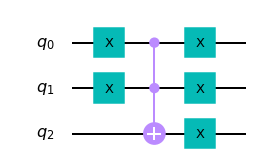

In [2]:
or_oracle = QuantumCircuit(3)
or_oracle.x(range(2))
or_oracle.ccx(0,1,2)
or_oracle.x(range(3))
# Do not change below this line
or_oracle.draw(output='mpl')

In [3]:
or_tt = ['000', '011', '101', '111']
def check_or_oracle(tt_row):
    check_qc = QuantumCircuit(3)
    for i in range(2):
        if (tt_row[i] == '1'):
            check_qc.x(i)
    check_qc.extend(or_oracle)
    check_qc.measure_all()
    return (execute(check_qc.reverse_bits(),backend=QasmSimulator(), shots=1).result().get_counts().most_frequent() == tt_row)
try:
    assert list(or_oracle.count_ops()) != [], f"Circuit cannot be empty"
    assert 'measure' not in or_oracle.count_ops(), f"Please remove measurements"
    assert set(or_oracle.count_ops().keys()).difference(basis_gates) == set(), f"Only the following basic gates are allowed: {basis_gates}"
    for tt_row in or_tt:     
        assert check_or_oracle(tt_row), f" Input {tt_row[0:2]}: Your encoding is not correct"
    print("Your oracle construction passed all checks")
except AssertionError as e:
    print(f'Your code has an error:  {e.args[0]}')
    
except Exception as e:
    print(f'This error occured: {e.args[0]}')

Your oracle construction passed all checks


## Linear functions and the Bernstein-Vazirani Algorithm
The Deutch-Jozsa algorithm allows us to distinguish between constant and balanced Boolean functions. There is an extension to the Deutsch-Jozsa algorithm that allows us to extract some information about a certain other class of functions. This is what we will be exploring in the next segment. 

An $n$-bit Boolean function $f(x)$ is called linear if it can be written as the bitwise product of a particular $n$-bit binary string $a$ and the function variable $x$ (which is  also a binary string of length $n$), i.e., linear functions can be written as 
$$f(x) = a\cdot x \;(\text{ mod } 2)$$

You might recall from the discussion on the Hadamard transform, that for any general $n$-qubit computational basis state, the Hadamard transform has the following effect
$$H^{\otimes n}|a\rangle = \frac{1}{2^{n/2}}\sum\limits_{x=0}^{n-1}(-1)^{a\cdot x}|x\rangle$$
Due to the self-inverting nature of the Hadamard transformation, we can apply $H^{\otimes n}$ to both sides of the above equation and get (after flipping sides)
$$H^{\otimes n} \left( \frac{1}{2^{n/2}}\sum\limits_{x=0}^{n-1}(-1)^{a\cdot x}|x\rangle \right) = |a\rangle$$
The term inside the brackets on the left hand side of the equation looks like what we would get if we passed an equal superposition state through a phase oracle for the Boolean function $f(x) = a\cdot x \;(\text{ mod } 2)$. This is depicted in the equation below:
$$\frac{1}{2^{n/2}}\sum\limits_{x=0}^{n-1}|x\rangle \xrightarrow{U_f} \frac{1}{2^{n/2}}\sum\limits_{x=0}^{n-1}(-1)^{a\cdot x}|x\rangle$$

The Bernstein-Vazirani algorithm uses all the things discussed above. Given an oracle for a function that we know is linear, we can find the binary string $a$ corresponding to the linear function. The steps of the algorithm are shown in the equation below and then described in words.
$$|0^{\otimes n}\rangle \xrightarrow{H^{\otimes n}} \frac{1}{2^{n/2}}\sum\limits_{x=0}^{n-1}|x\rangle \xrightarrow{U_f} \frac{1}{2^{n/2}}\sum\limits_{x=0}^{n-1}(-1)^{a\cdot x}|x\rangle \xrightarrow{H^{\otimes n}} |a\rangle$$
In the expression above, we've omitted (for readability) the mention of the extra qubit in the $|-\rangle$ state that is required for the oracle output, but it is necessary. 

## **Problem 2**
Consider the Boolean function $f(x) = (\overline{x_1} \wedge x_0) \vee (x_1 \wedge \overline{x_0})$. Take it as given that this function is a linear function. We want to find the 2-bit binary string $a$ such that the function. Your objective is to use this expression above to implement the quantum bit oracle for this Boolean function. 
This is more complex than any expression we have seen so far, so the implementation will be carried out in a few steps. 

A `QuantumCircuit()` with 3 qubits is provided below.
- $q_0$ and $q_1$ are the input qubits for the variables $x_0$ and $x_1$ respectively.
- $q_2$ is the output qubit and stores the value of the final Boolean function expression



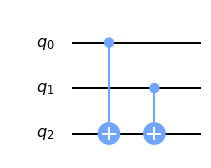

In [4]:
bv_oracle = QuantumCircuit(3)
bv_oracle.cx(0,2)
bv_oracle.cx(1,2)
bv_oracle.draw('mpl')

Using the bit oracle provided above, construct a circuit for the Bernstein-Vazirani algorithm.The  steps for the algorithm are as follows:
1. Start will $(n+1)$ qubits in the $|0\rangle$ state. Here $n=2$. These will serve as input to the oracle. We also need an extra qubit for the oracle output, since we need a phase oracle, add gates to prepare the state $|-\rangle$ in this qubit ($q_2$). 
2. Apply an $H$ gate to all the input qubits. 
3. Apply the oracle $U_f$ 
4. Apply an $H$ gate to all the input qubits. 
5. Measure the $n$ input qubits. 
If the function corresponding to  $U_f$ is linear, the final state measured will be the binary string $a$.

Astute readers will notice that the steps followed in the Bernstein-Vazirani and the Deutsch-jozsa algorithms are the same. `bv_circ` is a `QuantumCircuit(3,2)` given below. Add necessary operations to the circuit below to realise the steps for the Bernstein-Vazirani algorithm.

## **Solution**

1. The $|-\rangle$ state can be created using an $X$ gate followed by an $H$ gate or an $H$ gate followed by a $Z$ gate. 

The remaining steps have been solved in the circuit below. Note that this is not a unique oracle given for the Boolean function and using any equivalent oracle will also be correct. 

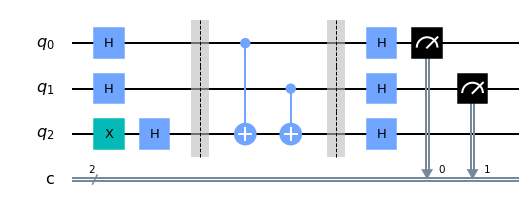

In [5]:
bv_circ = QuantumCircuit(3,2)
bv_circ.x(2)
bv_circ.h(range(3))

bv_circ.barrier()
# Extend the circuit using bv_oracle
bv_circ.extend(bv_oracle)

bv_circ.barrier()
# Apply the Hadamard transformation on all qubits and then measure q_0 and q_1
bv_circ.h(range(3))
bv_circ.measure([0,1], [0,1])
# Do not remove this line
bv_circ.draw(output='mpl')

 Your circuit produced the correct output. Please submit for evaluation.


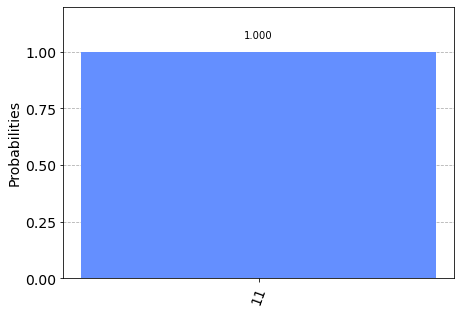

In [6]:
try:
    assert list(bv_circ.count_ops()) != [], f"Circuit cannot be empty"
    assert set(bv_circ.count_ops().keys()).difference(basis_gates) == set(), f"Only the following basic gates are allowed: {basis_gates}"
    counts = execute(bv_circ.reverse_bits(), backend=QasmSimulator(), shots=8192).result().get_counts()
    assert list(counts.keys()) == ['11'], "Your circuit did not produce the right answer"
    print(" Your circuit produced the correct output. Please submit for evaluation.")
except AssertionError as e:
    print(f'Your code has an error:  {e.args[0]}')
    
except Exception as e:
    print(f'This error occured: {e.args[0]}')
plot_histogram(counts)